In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image

Implement IG step by step

In [26]:
img_size = (224,224)
input_size = (224,224,3)
img_path = "fireboat.jpg"
class_index = 555
m_steps = 240
alpha = 0.4
model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=True, weights="imagenet", input_shape=input_size)
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [27]:
def interpolation(base, img, alphas):
    # convert alpha from 1D to 4D
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]

    # add batchsize, shape will be (batch, h, w, channel)
    base_x = tf.expand_dims(base, axis=0)
    input_x = tf.expand_dims(img, axis=0)

    delta = input_x - base_x
    images = base_x + alphas_x * delta
    return images

def compute_grad(images, class_index):
   with tf.GradientTape() as tape:
      tape.watch(images)
      logits = model(images)
      probs = logits[:, class_index]
      return tape.gradient(probs, images)

def integral_approximation(gradients):
  # riemann_trapezoidal   ([(x[0]+x[1])/2.0] + [....] + [...] )/m
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

def integrated_gradients(baseline,
                         image,
                         class_index,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, class_index)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

@tf.function
def one_batch(baseline, image, alpha_batch, class_index):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolation(base=baseline,
                                                       img=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_grad(images=interpolated_path_input_batch,
                                       class_index=class_index)
    return gradient_batch

def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=img_size)
  return image

<class 'tensorflow.python.framework.ops.EagerTensor'>


Text(0.5, 1.0, 'Baseline')

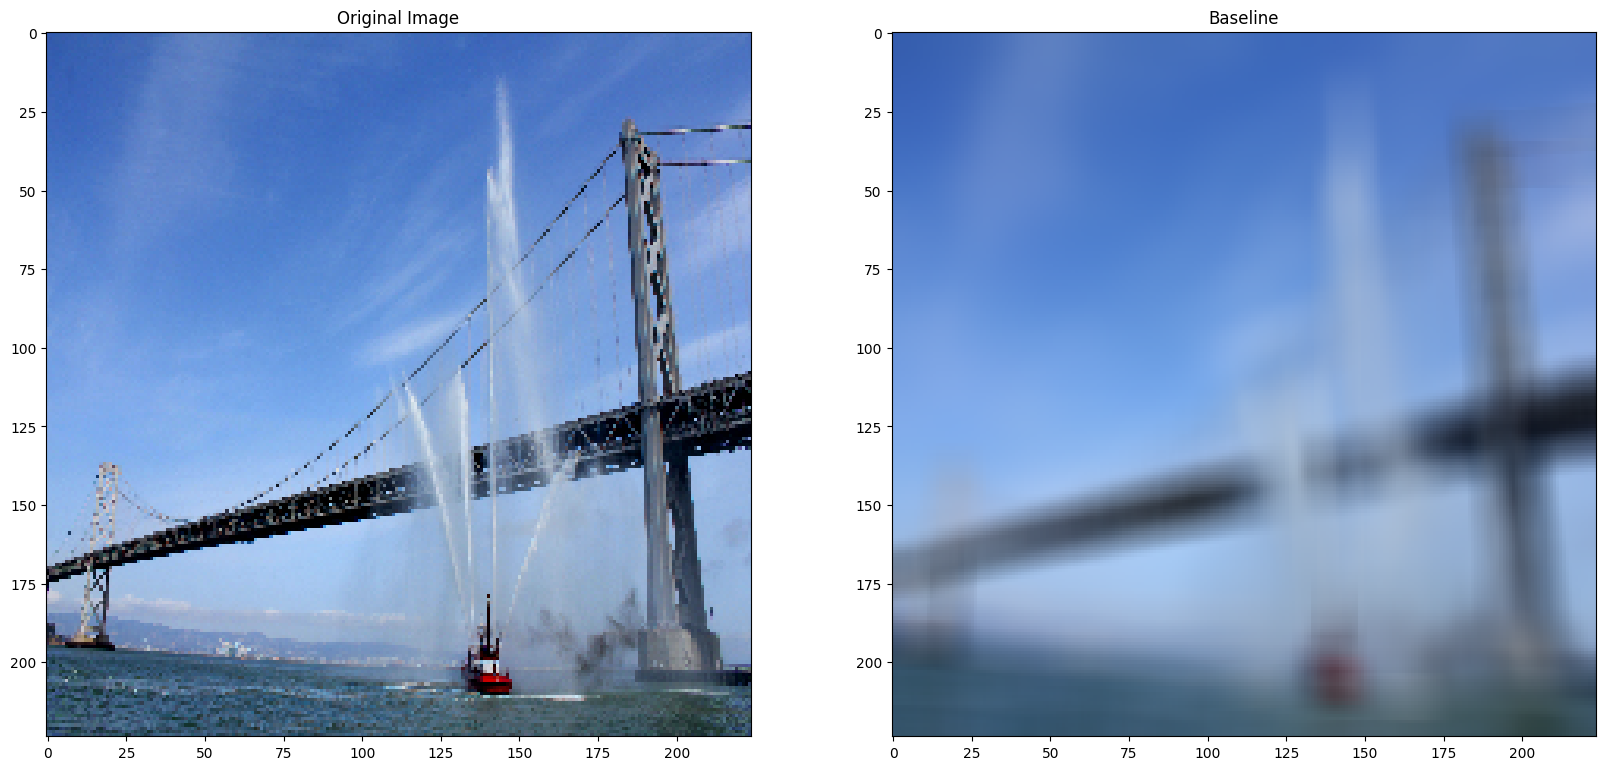

In [28]:

img = read_image("fireboat.jpg")
base = tf.image.resize(img, img_size)
base = tf.nn.avg_pool(base[None], ksize=15, strides=1, padding='SAME')[0]
print(type(img))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(base)
plt.title("Baseline")

In [29]:
def plot_img_attributions(base,
                          img,
                          class_index,
                          m_steps=10,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=base,
                                      image=img,
                                      class_index=class_index,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  plt.title("IG Before Softmax")
  plt.imshow(attribution_mask, cmap=cmap)
  plt.imshow(img, alpha=overlay_alpha)
  plt.axis('off')

  plt.tight_layout()

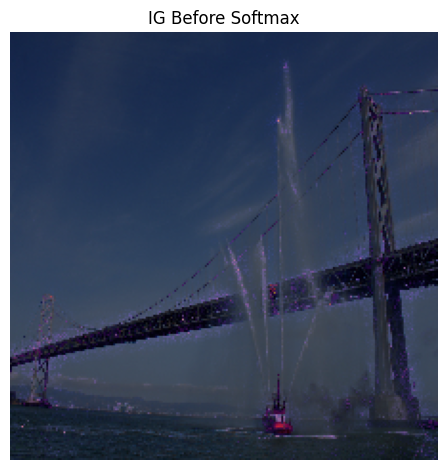

In [30]:
_ = plot_img_attributions(img=read_image(img_path),
                          base=base,
                          class_index=555,
                          m_steps=250,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)